### Lista de Exercício 3
### Luís Filipe Loureiro

- Modificar a ideia 1 da aula de hoje para simular pares de até 3 ações americanas correlacionadas.
- Selecionar entre 1 ano e 2 anos de dados
- Precisa ajustar as quantidades para que tenham o mesmo valor financeiro. As quantidades serão inteiros múltiplos de 1.


In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import coint
import statsmodels.tsa.stattools as st
import time
from datetime import datetime
import random
import yahoofinancials as yf
import pandas.testing as tm
from statsmodels.tsa.stattools import adfuller
from scipy.stats import spearmanr

# Para fazer o backtesting
from backtesting_v2_1 import TradingSystem, MarketData, Order, Strategy, Event, evaluateHist

### Escolha do par de ações

Vamos analisar empresas de tecnologia americanas


In [17]:
# Top 3 ações de tech
Tech = ['AAPL', 'MSFT', 'GOOG'] #etc

#puxar as séries:

for ticker in Tech:

    start_date = '2018-05-10'
    end_date =  '2020-05-10'

    data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')

    # Ler os dados do JSON
    raw = pd.DataFrame(data[ticker]['prices']).dropna()
    # Converter a data para o tipo correto datetime
    raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
    # Indica a data como o índice de cada linha
    raw = raw.set_index('formatted_date')
    # Removendo as colunas que não interessam
    df = raw.iloc[:,1:]

    # Acertando a ordem das colunas
    df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
    # Salvando o CSV
    df.to_csv('{}.csv'.format(ticker))
            

In [20]:
# Montar os pares e testar:
for i in range(len(Tech)):
    for j in range(i+1, len(Tech)):
        ticker1 = Tech[i]
        ticker2 = Tech[j]
        
        if ticker1 != ticker2:
            data1 = pd.read_csv('{}.csv'.format(ticker1))
            data2 = pd.read_csv('{}.csv'.format(ticker2))
            
            
            data1.set_index('formatted_date')
            data2.set_index('formatted_date')

            # Junção dos dois dataframes, usando a data como chave comum

            pair = data1.join(data2, how='inner', lsuffix='_1', rsuffix='_2')
            print('{}/{}:'.format(ticker1, ticker2))
            print(spearmanr(pair.adjclose_1, pair.adjclose_2))

            diff = pair.adjclose_1.pct_change().dropna()-pair.adjclose_2.pct_change().dropna()
            adf, pvalue, *_ = adfuller(diff)
            print('ADFuller: {}'.format(pvalue))


AAPL/MSFT:
SpearmanrResult(correlation=0.8261181398115577, pvalue=6.777041714191056e-127)
ADFuller: 0.0
AAPL/GOOG:
SpearmanrResult(correlation=0.7773616945681763, pvalue=6.356698333995024e-103)
ADFuller: 4.423103402841916e-29
MSFT/GOOG:
SpearmanrResult(correlation=0.7198535102621092, pvalue=1.7962223709917817e-81)
ADFuller: 0.0


Pelo resultado a cima, vamos seguir com o par AAPL/MSFT, dado a correlação (0.83), pvalue que tende a zero indicando descartar a hipótese nula. Além disso, o teste  Dick Fuller Test, dado seu valor nulo, indica que ela não é estacionária

### Análise do par AAPL/MSFT

In [21]:
ticker = 'AAPL'
AAPL = pd.read_csv('{}.csv'.format(ticker))
AAPL

,formatted_date,open,high,low,close,adjclose,volume
0,2018-05-10,46.935001,47.592499,46.912498,47.509998,45.292282,111957200
1,2018-05-11,47.372501,47.514999,46.862499,47.147499,45.120026,104848800
2,2018-05-14,47.252499,47.382500,46.965000,47.037498,45.014751,83115200
3,2018-05-15,46.695000,46.767502,46.275002,46.610001,44.605644,94780800
4,2018-05-16,46.517502,47.115002,46.500000,47.044998,45.021942,76732400
...,...,...,...,...,...,...,...
498,2020-05-04,72.292503,73.422501,71.580002,73.290001,71.861244,133568000
499,2020-05-05,73.764999,75.250000,73.614998,74.389999,72.939812,147751200
500,2020-05-06,75.114998,75.809998,74.717499,75.157501,73.692337,142333600
501,2020-05-07,75.805000,76.292503,75.492500,75.934998,74.454681,115215200


In [22]:
ticker = 'MSFT'
MSFT = pd.read_csv('{}.csv'.format(ticker))
MSFT

,formatted_date,open,high,low,close,adjclose,volume
0,2018-05-10,97.459999,97.949997,97.050003,97.910004,92.404976,22388100
1,2018-05-11,97.800003,97.870003,97.040001,97.699997,92.206787,16778300
2,2018-05-14,97.919998,98.690002,97.309998,98.029999,92.518227,19454100
3,2018-05-15,97.239998,97.849998,96.339996,97.320000,91.848152,24594000
4,2018-05-16,97.360001,97.400002,96.620003,97.150002,92.085114,17384700
...,...,...,...,...,...,...,...
498,2020-05-04,174.490005,179.000000,173.800003,178.839996,173.904449,30372900
499,2020-05-05,180.619995,183.649994,179.899994,180.759995,175.771423,36839200
500,2020-05-06,182.080002,184.199997,181.630005,182.539993,177.502319,32139300
501,2020-05-07,184.169998,184.550003,182.580002,183.600006,178.533051,28316000


In [23]:
# Atribui os índices nos dataframes à data

AAPL.set_index('formatted_date')
MSFT.set_index('formatted_date')

# Junção dos dois dataframes, usando a data como chave comum

AAPL_MSFT = AAPL.join(MSFT, how='inner', lsuffix='_A', rsuffix='_M')

# Novo dataframe com a união dos dois anteriores
AAPL_MSFT

,formatted_date_A,open_A,high_A,low_A,close_A,adjclose_A,volume_A,formatted_date_M,open_M,high_M,low_M,close_M,adjclose_M,volume_M
0,2018-05-10,46.935001,47.592499,46.912498,47.509998,45.292282,111957200,2018-05-10,97.459999,97.949997,97.050003,97.910004,92.404976,22388100
1,2018-05-11,47.372501,47.514999,46.862499,47.147499,45.120026,104848800,2018-05-11,97.800003,97.870003,97.040001,97.699997,92.206787,16778300
2,2018-05-14,47.252499,47.382500,46.965000,47.037498,45.014751,83115200,2018-05-14,97.919998,98.690002,97.309998,98.029999,92.518227,19454100
3,2018-05-15,46.695000,46.767502,46.275002,46.610001,44.605644,94780800,2018-05-15,97.239998,97.849998,96.339996,97.320000,91.848152,24594000
4,2018-05-16,46.517502,47.115002,46.500000,47.044998,45.021942,76732400,2018-05-16,97.360001,97.400002,96.620003,97.150002,92.085114,17384700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2020-05-04,72.292503,73.422501,71.580002,73.290001,71.861244,133568000,2020-05-04,174.490005,179.000000,173.800003,178.839996,173.904449,30372900
499,2020-05-05,73.764999,75.250000,73.614998,74.389999,72.939812,147751200,2020-05-05,180.619995,183.649994,179.899994,180.759995,175.771423,36839200
500,2020-05-06,75.114998,75.809998,74.717499,75.157501,73.692337,142333600,2020-05-06,182.080002,184.199997,181.630005,182.539993,177.502319,32139300
501,2020-05-07,75.805000,76.292503,75.492500,75.934998,74.454681,115215200,2020-05-07,184.169998,184.550003,182.580002,183.600006,178.533051,28316000


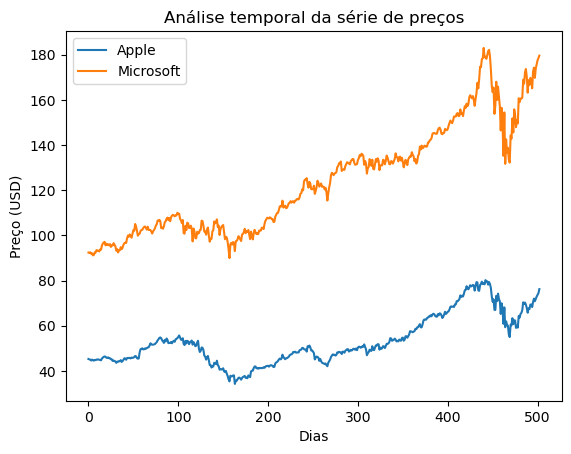

In [24]:
plt.plot(AAPL_MSFT.adjclose_A, label="Apple")
plt.plot(AAPL_MSFT.adjclose_M, label="Microsoft")
plt.legend(loc="upper left")
plt.title("Análise temporal da série de preços")
plt.ylabel("Preço (USD)")
plt.xlabel("Dias")
plt.show()

Text(0.5, 1.0, 'Dispersão dos preços de fechamento')

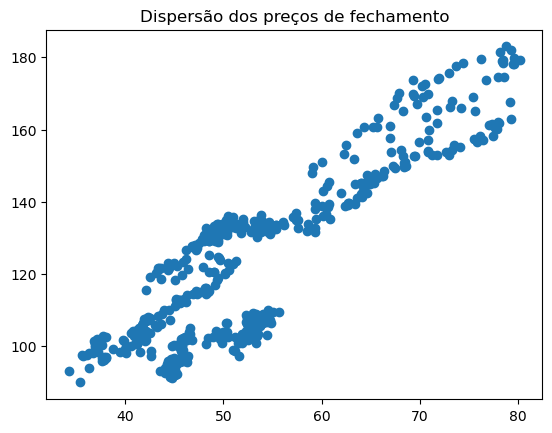

In [25]:
plt.scatter(AAPL_MSFT.adjclose_A, AAPL_MSFT.adjclose_M)
plt.title("Dispersão dos preços de fechamento")

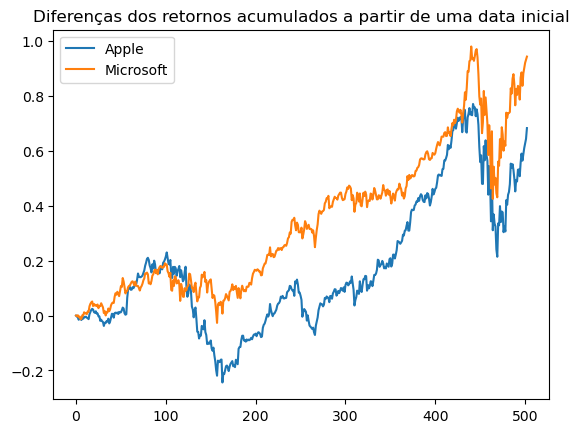

In [26]:
retA = AAPL_MSFT.adjclose_A/AAPL_MSFT.adjclose_A[0]-1
plt.plot(retA, label="Apple");
retM = AAPL_MSFT.adjclose_M/AAPL_MSFT.adjclose_M[0]-1
plt.plot(retM, label="Microsoft");
plt.legend(loc="upper left")
plt.title("Diferenças dos retornos acumulados a partir de uma data inicial")
plt.show()

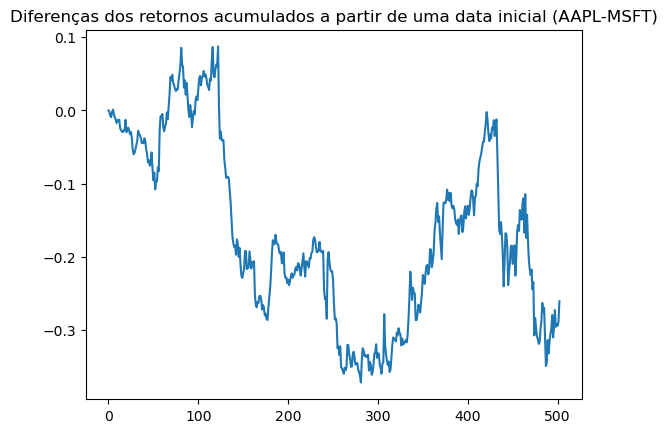

In [27]:
plt.title("Diferenças dos retornos acumulados a partir de uma data inicial (AAPL-MSFT)")
plt.plot(retA-retM);

O retorno acumulado não sugere uma boa oportunidade de arbirtragem, dado a sua alta variação

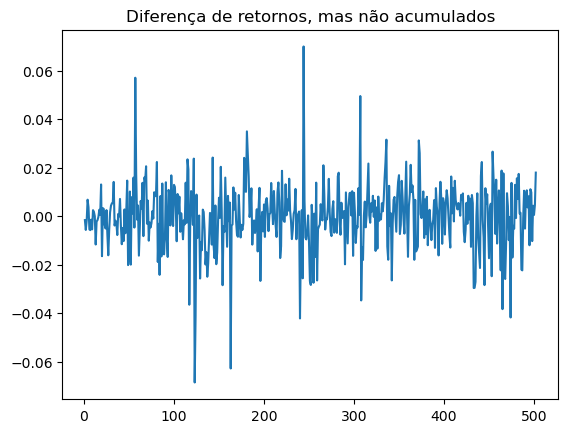

In [28]:
AAPL_MSFT['diff'] = AAPL_MSFT.adjclose_A.pct_change()-AAPL_MSFT.adjclose_M.pct_change()
AAPL_MSFT = AAPL_MSFT.dropna()
plt.plot(AAPL_MSFT['diff'])
plt.title("Diferença de retornos, mas não acumulados")
plt.show()

In [29]:
metrics = AAPL_MSFT['diff'].describe()
metrics

count    502.000000
mean      -0.000257
std        0.013471
min       -0.068597
25%       -0.006901
50%        0.000330
75%        0.007526
max        0.069913
Name: diff, dtype: float64

### Trading Idea:
- Se o índice (diff) estiver acima do terceiro quartil, vende o spread (muito positivo, vende Apple e compra Microsoft)
- Se o índice (diff) estiver abaixo do primeiro quartil, compra o spread (muito negativo, compra Apple e vende Microsoft)

In [31]:
AAPL_MSFTdiff = pd.DataFrame({'formatted_date': AAPL_MSFT['formatted_date_A'],
                    'close_A': AAPL_MSFT['close_A'],
                    'close_M': AAPL_MSFT['close_M'],
                    'low': AAPL_MSFT['low_A'],
                    'close': AAPL_MSFT['close_A'],
                    'adjclose': AAPL_MSFT['diff'],
                    'volume': 0,
                   })
AAPL_MSFTdiff = AAPL_MSFTdiff.set_index('formatted_date')
AAPL_MSFTdiff

,close_A,close_M,low,close,adjclose,volume
formatted_date,,,,,,
2018-05-11,47.147499,97.699997,46.862499,47.147499,-0.001658,0
2018-05-14,47.037498,98.029999,46.965000,47.037498,-0.005711,0
2018-05-15,46.610001,97.320000,46.275002,46.610001,-0.001846,0
2018-05-16,47.044998,97.150002,46.500000,47.044998,0.006753,0
2018-05-17,46.747501,96.180000,46.590000,46.747501,0.003661,0
...,...,...,...,...,...,...
2020-05-04,73.290001,178.839996,71.580002,73.290001,-0.010311,0
2020-05-05,74.389999,180.759995,73.614998,74.389999,0.004273,0
2020-05-06,75.157501,182.539993,74.717499,75.157501,0.000470,0


In [32]:
AAPL_MSFTdiff.to_csv('AAPL_MSFTdiff.csv')

### Racional


Criei uma variável self.equilibrium que serve para ser a razão entre os preços das ações, dado seus preços diferentes. 

A variável self.equilibrium_Zeragem serve para armazenar a razão passada que fora comprada. Ela receber o valor do self.equilibrium, após a zeragem da posição.

Os valores de close da Apple e Microsoft entraram no data frame que entrou na estratégia do backtesting.

A variável self.equilibrium_signal serve para indicar qual ação está maior, ela será 0 caso for Apple, 1 se for Microsoft e -1 caso os preços sejam iguais. 

self.equilibrium_Zeragem_signal é equivalente para a zeragem da posição passada.



### Backtesting

In [38]:
class LongShort(Strategy):
    
    def __init__(self, uband, lband):
        self.prices = []
        self.indicator = []
        self.pricesA = [] #armazena preços da apple
        self.pricesM = [] #armazena preços da microsoft
        
        self.equilibrium = 0 #multiplicador de equivalencia de preços
        self.equilibrium_signal = -1
        self.equilibrium_Zeragem = 0 # multiplicador para zerar a posição passada
        self.equilibrium_Zeragem_signal = -1
        self.side = 0
        
        self.uband = uband
        self.lband = lband
        
        
    def receive(self, event):
        
        orders = []
        
        
        
     
    
        if event.instrument == 'AAPL_MSFTdiff':
            

            price = event.price[3] # Captura o spread
            priceA = event.price[0]
            priceM = event.price[1]
            
            #Série de preços das ações
            self.pricesA.append(priceA)
            self.pricesM.append(priceM)
            
            # Equivalência de preços
            if (priceA/priceM) > 1:
                self.equilibrium = round((priceA/priceM)*10)
                self.equilibrium_signal = 0
                
            elif (priceA/priceM) < 1:
                self.equilibrium = round((priceM/priceA)*10)
                self.equilibrium_signal = 1
                
            else:
                self.equilibrium = 10
                self.equilibrium_signal = -1
            
            
            
            # Montando a série de preços:
            self.prices.append(price)

            if price > self.uband:
                signal = -1 # Sell PETR3, buy PETR4
            elif price < self.lband:
                signal = 1 # Buy PETR3, sell PETR4

            if self.side != signal:

                
                
                # Zerando antiga posição 
                if self.side > 0: # Se está comprado em AAPL, vende AAPL e compra MSFT
                    if self.equilibrium_Zeragem_signal == 0: # Apple era maior que MSFT 
                        self.submit(self.id, Order('AAPL', Order.S, 10*self.side, 0))
                        self.submit(self.id, Order('MSFT', Order.B, self.equilibrium_Zeragem*self.side, 0))
                        
                    elif self.equilibrium_Zeragem_signal == 1: # Microsoft era maior que Apple
                        self.submit(self.id, Order('AAPL', Order.S, self.equilibrium_Zeragem*self.side, 0))
                        self.submit(self.id, Order('MSFT', Order.B, 10*self.side, 0))
                        
                    else: # Se no momento da operação, ações tinham os mesmos preços
                        self.submit(self.id, Order('AAPL', Order.S, 10*self.side, 0))
                        self.submit(self.id, Order('MSFT', Order.B, 10*self.side, 0))
                        
                     
                elif self.side < 0: # Senão faz o inverso
                    if self.equilibrium_Zeragem_signal == 0: # Apple era maior que MSFT 
                        self.submit(self.id, Order('AAPL', Order.B, 10*self.side, 0))
                        self.submit(self.id, Order('MSFT', Order.S, self.equilibrium_Zeragem*self.side, 0))
                        
                    elif self.equilibrium_Zeragem_signal == 1: # Apple era maior que MSFT 
                        self.submit(self.id, Order('AAPL', Order.B, self.equilibrium_Zeragem*self.side, 0))
                        self.submit(self.id, Order('MSFT', Order.S, 10*self.side, 0))
                    
                    else: # Se no momento da operação, ações tinham os mesmos preços
                        self.submit(self.id, Order('AAPL', Order.B, 10*self.side, 0))
                        self.submit(self.id, Order('MSFT', Order.S, 10*self.side, 0))
                    
                    
                # Montando nova posição 
                if signal > 0: # Se quer comprar AAPL, compra AAPL e vende MSFT
                    if self.equilibrium_signal == 0: # Apple é maior que MSFT                        
                        self.submit(self.id, Order('AAPL', Order.B, 10*signal, 0))
                        self.submit(self.id, Order('MSFT', Order.S, self.equilibrium *signal, 0))
                        self.equilibrium_Zeragem_signal = 0
                        
                    elif self.equilibrium_signal == 1: # Microsoft maior que Apple
                        self.submit(self.id, Order('AAPL', Order.B, self.equilibrium*signal, 0))
                        self.submit(self.id, Order('MSFT', Order.S, 10 *signal, 0))
                        self.equilibrium_Zeragem_signal = 1
                        
                    else: # Ativos com mesmo preço
                        self.submit(self.id, Order('AAPL', Order.B, 10*signal, 0))
                        self.submit(self.id, Order('MSFT', Order.S, 10 *signal, 0))
                        self.equilibrium_Zeragem_signal = -1
                        
                elif signal < 0: # Senão faz o inverso
                    if self.equilibrium_signal == 0: # Apple é maior que MSFT
                        self.submit(self.id, Order('AAPL', Order.S, 10*signal, 0))
                        self.submit(self.id, Order('MSFT', Order.B, self.equilibrium*signal, 0))
                        self.equilibrium_Zeragem_signal = 0
                        
                    elif self.equilibrium_signal == 1: # Microsoft maior que Apple
                        self.submit(self.id, Order('AAPL', Order.S, self.equilibrium*signal, 0))
                        self.submit(self.id, Order('MSFT', Order.B, 10*signal, 0))
                        self.equilibrium_Zeragem_signal = 1
                        
                    else:
                        self.submit(self.id, Order('AAPL', Order.S, 10*signal, 0))
                        self.submit(self.id, Order('MSFT', Order.B, 10*signal, 0))
                        self.equilibrium_Zeragem_signal = -1
                        
                    self.equilibrium_Zeragem = self.equilibrium
                    
                        
                        

                self.side = signal
        
        return orders
    
    
model = LongShort(metrics[4], metrics[6])
print(evaluateHist(model, {'AAPL': 'AAPL.csv', 'MSFT': 'MSFT.csv', 'AAPL_MSFTdiff': 'AAPL_MSFTdiff.csv'}))

Gross Profit: $94.54
Gross Loss: $-218.22
Gross Total: $-123.68

Number of trades: 18
Hitting Ratio: 66.67%
Number of profit trades: 12
Number of loss trades: 6
Average number of events per trade: 27.83

Max win trade: $21.32
Avg win trade: $7.88
Max loss trade: $-172.78
Avg loss trade: $-36.37
Avg all trades: $-6.87
Win/Loss ratio: 0.22

Max Profit: $186.25
Max Profit High/Low: $191.82
Max Drawdown: $-681.44
Max Drawdown High/Low: $-569.22

Max Allocation: $2065.94
Avg Allocation: $1043.12
Max Cash Required (margin): $2065.94

Gross Total: $-123.68
Total Fees: $57.40
Total Taxes: $17.77
Net Total: $-198.85

Gross Return: -3.47%
Average Return: -0.19%
Net Return: -8.24%
Net Return Avg Alocation: -19.06%

Number of days: 503
Initial Capital: $10000.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $2538.47
Net Total + Carry: $2339.62
Net Return Capital: 23.40%
Net Return Capital Yearly: 11.11%




### Resultado

Resultado foi razoável, com um retorno sobre capital anualizado de 11.11% e Hitting Ratio de 66.67%. No período de 2 anos, foram feitos 18 trades.

In [41]:
print("Para o código completo: ")
print("https://github.com/LuisFilipeMLoureiro/AlgoTrading")

Para o código completo: 
https://github.com/LuisFilipeMLoureiro/AlgoTrading


In [40]:
print("EOF")

EOF
